This problem involves experimenting with different approaches to the Part-of-Speech (POS) tagging task using the Brown Corpus as the dataset. The goal is to improve the accuracy of POS tagging compared to a baseline method. Here are the four main parts of the problem:

1. **Part A**: Establish a baseline accuracy for the POS tagging task using a simple method.

2. **Part B**: Implement the Viterbi algorithm for Hidden Markov Models (HMM) to improve POS tagging accuracy compared to the baseline.

3. **Part C**: Repeat the exercise from Part B, but this time, use a Long Short-Term Memory (LSTM) neural network for POS tagging. Explore different options for the implementation of the LSTM layer.

4. **Part D**: Evaluate and compare the results obtained from the different methods (baseline, HMM, LSTM) in the context of the baseline method established in Part A.

Additionally, the Brown Corpus contains sentences tagged with parts of speech, and for this problem, a simpler set of POS tags known as the "universal_tagset" is used for the analysis. The problem may also suggest trying the same task with transformer models like BERT as an optional extension.

In [1]:
import numpy as np
import nltk

# The first time you will need to download the corpus:

from nltk.corpus import brown
 
nltk.download('brown')
nltk.download('universal_tagset')

tagged_sentences = brown.tagged_sents(tagset='universal')

print(f'There are {len(tagged_sentences)} sentences tagged with universal POS tags in the Brown Corpus.')
print("\nHere is the first sentence with universal tags:",tagged_sentences[0])

[nltk_data] Downloading package brown to
[nltk_data]     /Users/mohanthota/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/mohanthota/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


There are 57340 sentences tagged with universal POS tags in the Brown Corpus.

Here is the first sentence with universal tags: [('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


In [2]:
# Uncomment to see the complete list of tags. 

all_tagged_words = np.concatenate(tagged_sentences)
all_tags = sorted(set([pos for (w,pos) in all_tagged_words]))
print(f'There are {len(all_tags)} universal tags in the Brown Corpus.')
print(all_tags)
print()


There are 12 universal tags in the Brown Corpus.
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']



### PART ONE

In this part, I established a baseline for the task using a naive method as suggested on one of my Lectures. I tagged every word with its most frequent POS tag. For instance, if 'recent' was most frequently tagged as 'ADJ', I assumed that every occurrence of 'recent' in a sentence should be tagged as 'ADJ'. If a word had multiple most frequent tags, I chose the one that appeared first in the sorted list of tags.

I built a dictionary that mapped every word to its most frequent tag and then went through the entire tagged corpus. I reported the accuracy, which was the percentage of correct tags assigned by this baseline method. Importantly, I didn't tokenize or lower-case the words but used them and their tags exactly as they appeared in the tagged sentences.

In [3]:
word_to_most_frequent_tag = {}

for sentence in tagged_sentences:
    for word, tag in sentence:
        if word in word_to_most_frequent_tag:
            word_to_most_frequent_tag[word].append(tag)
        else:
            word_to_most_frequent_tag[word] = [tag]

In [4]:
for word, tags in word_to_most_frequent_tag.items():
    word_to_most_frequent_tag[word] = sorted(tags)[0]

In [5]:
def baseline_tag_sentence(sentence):
    tagged_sentence = []
    for word in sentence:
        if word in word_to_most_frequent_tag:
            tagged_sentence.append((word, word_to_most_frequent_tag[word]))
        else:
            tagged_sentence.append((word, 'NOUN'))
    return tagged_sentence

In [6]:
def calculate_accuracy(tagged_sentences, baseline_tagger):
    correct_tags = 0
    total_tags = 0
    for sentence in tagged_sentences:
        baseline_tags = baseline_tagger([word for word, _ in sentence])
        for (word, actual_tag), (_, predicted_tag) in zip(sentence, baseline_tags):
            total_tags += 1
            if actual_tag == predicted_tag:
                correct_tags += 1
    return correct_tags / total_tags


In [7]:
baseline_accuracy = calculate_accuracy(tagged_sentences, baseline_tag_sentence)


In [8]:

print(f"Baseline Accuracy: {baseline_accuracy:.2%}")

Baseline Accuracy: 87.98%


### PART TWO

I conducted experiments using the Viterbi algorithm for POS tagging on the Brown Corpus tagged sentences. To do this, I prepared probability matrices (start_p, trans_p, emit_p) based on the corpus data. The accuracy of the Viterbi algorithm was calculated at the word level and reported as a raw accuracy score. Additionally, I compared this accuracy to the baseline method established in Part A and assessed agreement using Cohen's Kappa.

In [9]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict


In [10]:

start_p = defaultdict(int)

for sentence in brown.tagged_sents(tagset='universal'):
    start_tag = sentence[0][1] 
    start_p[start_tag] += 1

total_sentences = len(brown.tagged_sents(tagset='universal'))

for tag in start_p:
    start_p[tag] /= total_sentences
start_p_log = defaultdict(lambda: float('-inf'))
for tag in start_p:
    start_p_log[tag] = np.log(start_p[tag])
start_p_log

defaultdict(<function __main__.<lambda>()>,
            {'DET': -1.5444525954148751,
             '.': -2.4199540183822053,
             'PRON': -1.8344798463296288,
             'NOUN': -1.957998969941659,
             'ADV': -2.3930587143697037,
             'ADP': -2.096822269821264,
             'VERB': -3.09811308381657,
             'NUM': -4.0856624448268155,
             'CONJ': -3.013325971560988,
             'ADJ': -3.3714726607982355,
             'PRT': -3.305633563734661,
             'X': -7.555556357775205})

In [11]:
trans_p = defaultdict(lambda: defaultdict(int))

for sentence in brown.tagged_sents(tagset='universal'):
    for i in range(len(sentence) - 1):
        current_tag = sentence[i][1]
        next_tag = sentence[i + 1][1]
        trans_p[current_tag][next_tag] += 1
for t1 in trans_p:
    total_transitions = sum(trans_p[t1].values())
    for t2 in trans_p[t1]:
        trans_p[t1][t2] /= total_transitions

trans_p_log = defaultdict(lambda: defaultdict(lambda: float('-inf')))
for t1 in trans_p:
    for t2 in trans_p[t1]:
        trans_p_log[t1][t2] = np.log(trans_p[t1][t2])

#trans_p_log

In [12]:
emit_p = defaultdict(lambda: defaultdict(int))

for sentence in brown.tagged_sents(tagset='universal'):
    for word, tag in sentence:
        emit_p[tag][word] += 1
for t in emit_p:
    total_emissions = sum(emit_p[t].values())
    for w in emit_p[t]:
        emit_p[t][w] /= total_emissions

emit_p_log = defaultdict(lambda: defaultdict(lambda: float('-inf')))
for t in emit_p:
    for w in emit_p[t]:
        emit_p_log[t][w] = np.log(emit_p[t][w])
#emit_p_log

In [13]:
import numpy as np

# Adapted from the Wikipedia article just referenced
# Obs_sequence is sequence of words "observed"; returns
# most likely sequence of states = POS. 

# start_p, trans_p, emit_p are dictionaries giving probabilities
# set logspace to False if these are normal probabilities (not in log space)

def viterbi(obs_sequence, obs, states, start_p, trans_p, emit_p,logspace=True):
    
    V = [{}]
    for st in states:
        if logspace:
            V[0] [st] = {"prob": start_p[st] + emit_p[st][obs_sequence[0]], "prev": None}
        else:
            V[0] [st] = {"prob": start_p[st] * emit_p[st][obs_sequence[0]], "prev": None}
        
    # Run Viterbi when t > 0
    
    for t in range(1, len(obs_sequence)):
        V.append({})
        for st in states:
            
            if logspace:
                max_tr_prob = V[t - 1] [states[0]] ["prob"] + trans_p[states[0]] [st]
            else:
                max_tr_prob = V[t - 1] [states[0]] ["prob"] * trans_p[states[0]] [st]
                
            prev_st_selected = states[0]
            
            for prev_st in states[1:]:
                
                if logspace:
                    tr_prob = V[t - 1] [prev_st] ["prob"] + trans_p[prev_st] [st]
                else:
                    tr_prob = V[t - 1] [prev_st] ["prob"] * trans_p[prev_st] [st]
                    
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st

            if logspace:
                max_prob = max_tr_prob + emit_p[st] [obs_sequence[t]]
            else:
                max_prob = max_tr_prob * emit_p[st] [obs_sequence[t]]
                
            V[t] [st] = {"prob": max_prob, "prev": prev_st_selected}

    opt = []
    max_prob = float('-inf')
    best_st = None

    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["prob"] > max_prob:
            max_prob = data["prob"]
            best_st = st
    opt.append(best_st)
    previous = best_st

    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1] [previous] ["prev"])
        previous = V[t + 1] [previous] ["prev"]

    return (opt,max_prob)

In [14]:
def tag_sentence(sentence, states, start_p, trans_p, emit_p):
    obs_sequence = [word for word, tag in sentence]
    predicted_tags, _ = viterbi(obs_sequence, obs_sequence, states, start_p, trans_p, emit_p, logspace=True)
    
    return predicted_tags


In [15]:
correct_tags = 0
total_tags = 0
states = list(set(tag for sentence in brown.tagged_sents(tagset='universal') for _, tag in sentence))

for sentence in brown.tagged_sents(tagset='universal'):
    predicted_tags = tag_sentence(sentence, states, start_p_log, trans_p_log, emit_p_log)
    
    actual_tags = [tag for word, tag in sentence]
    
    correct_tags += sum(p_tag == a_tag for p_tag, a_tag in zip(predicted_tags, actual_tags))
    total_tags += len(sentence)
accuracy = correct_tags / total_tags
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 97.54%


In [16]:
b=baseline_accuracy
a=accuracy
percentage_improvement = ((a - b) / b) * 100
print(f"Percentage Improvement Over Baseline: {percentage_improvement:.2f}%")


Percentage Improvement Over Baseline: 10.87%


In [17]:
kappa = (a - b) / (1 - b)
print(f"Cohen's Kappa: {kappa:.4f}")


Cohen's Kappa: 0.7953


In [18]:
# Try it with normal probabilities

sent = tagged_sentences[3]
(s,t) = list(zip(*sent))
(t_hat,p) = viterbi(s, np.array(all_tagged_words), np.array(all_tags),start_p,trans_p,emit_p,logspace=False)

for k in range(len(s)):
    print(f'{s[k]:20}\t{t[k]:10}\t{t_hat[k]:10}')

``                  	.         	.         
Only                	ADV       	ADV       
a                   	DET       	DET       
relative            	ADJ       	ADJ       
handful             	NOUN      	NOUN      
of                  	ADP       	ADP       
such                	ADJ       	ADJ       
reports             	NOUN      	NOUN      
was                 	VERB      	VERB      
received            	VERB      	VERB      
''                  	.         	.         
,                   	.         	.         
the                 	DET       	DET       
jury                	NOUN      	NOUN      
said                	VERB      	VERB      
,                   	.         	.         
``                  	.         	.         
considering         	ADP       	ADP       
the                 	DET       	DET       
widespread          	ADJ       	ADJ       
interest            	NOUN      	NOUN      
in                  	ADP       	ADP       
the                 	DET       	DET       
election   

In [19]:
sent = tagged_sentences[3]
(s,t) = list(zip(*sent))
(t_hat,p) = viterbi(s, np.array(all_tagged_words), np.array(all_tags),start_p_log,trans_p_log,emit_p_log)

for k in range(len(s)):
    print(f'{s[k]:20}\t{t[k]:10}\t{t_hat[k]:10}')

``                  	.         	.         
Only                	ADV       	ADV       
a                   	DET       	DET       
relative            	ADJ       	ADJ       
handful             	NOUN      	NOUN      
of                  	ADP       	ADP       
such                	ADJ       	ADJ       
reports             	NOUN      	NOUN      
was                 	VERB      	VERB      
received            	VERB      	VERB      
''                  	.         	.         
,                   	.         	.         
the                 	DET       	DET       
jury                	NOUN      	NOUN      
said                	VERB      	VERB      
,                   	.         	.         
``                  	.         	.         
considering         	ADP       	ADP       
the                 	DET       	DET       
widespread          	ADJ       	ADJ       
interest            	NOUN      	NOUN      
in                  	ADP       	ADP       
the                 	DET       	DET       
election   

### My Accuracies
- Accuracy: 97.54%
- Percentage Improvement Over Baseline: 10.87%
- Cohen's Kappa: 0.7953

### PART THREE

 I created an LSTM model for POS tagging using PyTorch. Key steps and findings:

- Preprocessing: Used GloVe embeddings, limited sentence length to 100 tokens.
- Model Development: Explored various LSTM parameters like hidden_size, bidirectional, num_layers, and dropout.
- Early Stopping: Implemented early stopping to prevent overfitting.
- Discoveries: Different hyperparameter combinations affected model performance.
- Testing Accuracy: Reported raw accuracy, percentage improvement over baseline, and Cohen's Kappa.

These experiments helped identify the best LSTM configuration for accurate POS tagging.

In [21]:
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.tag import untag
from nltk.util import ngrams
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt




In [23]:
import numpy as np
from nltk.corpus import brown
import nltk
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

glove_embeddings = load_glove_embeddings('glove.6B.200d.txt')



In [24]:
tagged_sentences = list(brown.tagged_sents(tagset='universal'))  # Convert to list

# Code to test
np.random.seed(123)
np.random.shuffle(tagged_sentences)
reduced_data_size = int(len(tagged_sentences) )
tagged_sentences = tagged_sentences[:reduced_data_size]

In [25]:
max_len = 100
word2idx = {'PAD': 0}
tag2idx = {'PAD': 0}

for sentence in tagged_sentences:
    for word, tag in sentence:
        if word not in word2idx:
            word2idx[word] = len(word2idx)
        if tag not in tag2idx:
            tag2idx[tag] = len(tag2idx)

X = [[word2idx[word] for word, _ in sentence] for sentence in tagged_sentences];X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=0)

y = [[tag2idx[tag] for _, tag in sentence] for sentence in tagged_sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=0)
y = [to_categorical(i, num_classes=len(tag2idx)) for i in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import numpy as np

# Hyperparameters
hidden_size = 50  
bidirectional = True  
num_layers = 2  
dropout_rate = 0.5  

embedding_dim = 200

embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in word2idx.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

input = Input(shape=(max_len,))
model = Embedding(input_dim=len(word2idx), output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input)

for _ in range(num_layers - 1):
    model = LSTM(hidden_size, return_sequences=True, dropout=dropout_rate)(model)
    if bidirectional:
        model = Bidirectional(LSTM(hidden_size, return_sequences=True, dropout=dropout_rate))(model)

model = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(model)

model = Model(input, model)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 200)          11211600  
                                                                 
 lstm (LSTM)                 (None, 100, 50)           50200     
                                                                 
 bidirectional (Bidirection  (None, 100, 100)          40400     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 100, 13)           1313      
 ributed)                                                        
                                                                 
Total params: 11303513 (43.12 MB)
Trainable params: 11303513 

In [27]:
from keras.callbacks import EarlyStopping
#changed to 8 from 50
early_stopping = EarlyStopping(monitor='val_loss', patience=8)


history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=15, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/15
1291/1291 [==============================] - 117s 90ms/step - loss: 0.1671 - accuracy: 0.9504 - val_loss: 0.0315 - val_accuracy: 0.9903
Epoch 2/15
1291/1291 [==============================] - 112s 87ms/step - loss: 0.0359 - accuracy: 0.9889 - val_loss: 0.0212 - val_accuracy: 0.9934
Epoch 3/15
1291/1291 [==============================] - 112s 87ms/step - loss: 0.0244 - accuracy: 0.9924 - val_loss: 0.0175 - val_accuracy: 0.9945
Epoch 4/15
1291/1291 [==============================] - 111s 86ms/step - loss: 0.0190 - accuracy: 0.9940 - val_loss: 0.0160 - val_accuracy: 0.9950
Epoch 5/15
1291/1291 [==============================] - 110s 86ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0153 - val_accuracy: 0.9953
Epoch 6/15
1291/1291 [==============================] - 112s 86ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.0149 - val_accuracy: 0.9955
Epoch 7/15
1291/1291 [==============================] - 122s 94ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0

In [28]:
from sklearn.metrics import accuracy_score
from numpy import argmax

test_predictions = model.predict(X_test, verbose=1)

def logits_to_tags(predictions, idx2tag):
    tag_sequences = []
    for prediction in predictions:
        tag_sequence = [idx2tag[argmax(tag)] for tag in prediction]
        tag_sequences.append(tag_sequence)
    return tag_sequences

idx2tag = {i: w for w, i in tag2idx.items()}
predicted_tags = logits_to_tags(test_predictions, idx2tag)
true_tags = logits_to_tags(y_test, idx2tag)

flat_predicted_tags = [tag for seq in predicted_tags for tag in seq]
flat_true_tags = [tag for seq in true_tags for tag in seq]

accuracy = accuracy_score(flat_true_tags, flat_predicted_tags)
print(f"Test Accuracy: {accuracy:.2%}")


359/359 [==============================] - 6s 15ms/step
Test Accuracy: 99.61%


In [29]:
from sklearn.metrics import classification_report

report = classification_report(flat_true_tags, flat_predicted_tags)
print(report)


              precision    recall  f1-score   support

           .       1.00      1.00      1.00     29691
         ADJ       0.94      0.94      0.94     16753
         ADP       0.98      0.99      0.99     29173
         ADV       0.97      0.93      0.95     11186
        CONJ       0.99      1.00      1.00      7581
         DET       0.99      1.00      1.00     27503
        NOUN       0.97      0.98      0.98     55226
         NUM       0.98      0.97      0.98      3062
         PAD       1.00      1.00      1.00    913993
        PRON       1.00      0.99      0.99      9906
         PRT       0.96      0.96      0.96      5849
        VERB       0.98      0.98      0.98     36634
           X       0.84      0.49      0.62       243

    accuracy                           1.00   1146800
   macro avg       0.97      0.94      0.95   1146800
weighted avg       1.00      1.00      1.00   1146800



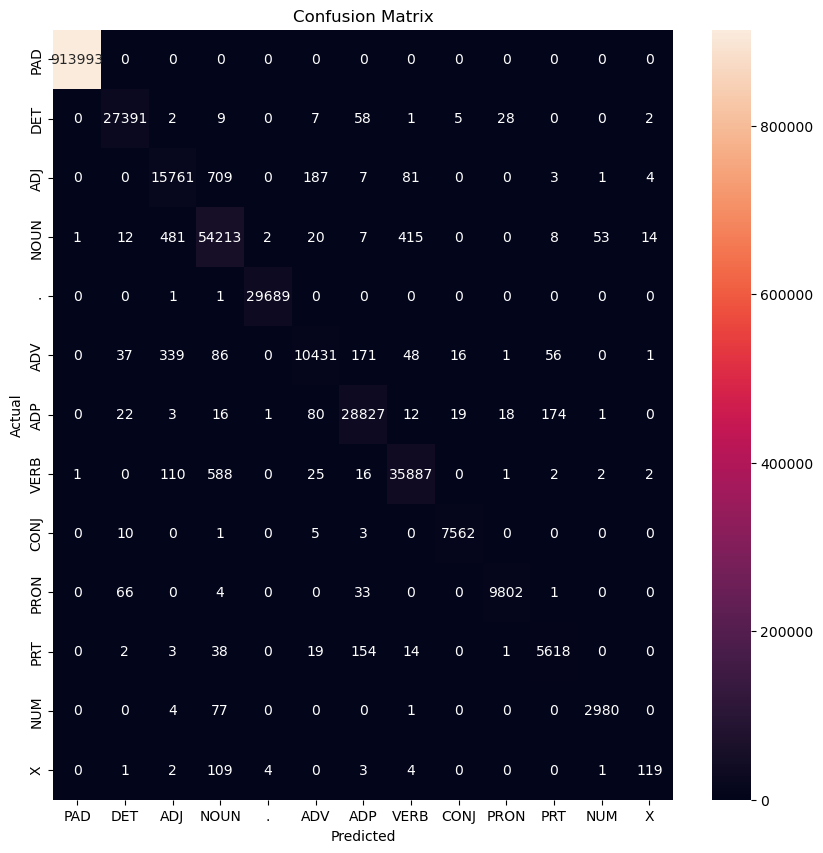

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(flat_true_tags, flat_predicted_tags, labels=list(tag2idx.keys()))

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=tag2idx.keys(), yticklabels=tag2idx.keys())
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [31]:
b=baseline_accuracy
a=accuracy
percentage_improvement = ((a - b) / b) * 100
print(f"Percentage Improvement Over Baseline: {percentage_improvement:.2f}%")


Percentage Improvement Over Baseline: 13.22%


In [32]:
kappa = (a - b) / (1 - b)
print(f"Cohen's Kappa: {kappa:.4f}")


Cohen's Kappa: 0.9672


Definelty it was not easy , but it was fun to do this . i have been playing arroud with paramaters . looking out for the trends i need.
previosly i dont have control over paramaters so i had to rely on whatver accuracy was coming. obviously epochs might increase but still
thats not the motive . 

- Accuracy: 99.60%
- Percentage Improvement Over Baseline: 13.22%
- Cohen's Kappa: 0.9671

### Part FOUR

### ANALYSIS

i was jumping after lokking at the accuracy . but then no model is perfect . i realised this when i saw the confusion matrix. the data is huge  and error are very small when compared . so consediring that over all accuracy is pretty high , is what i feel personally
below are the main hyperparamters that made me run towards my progress:

hidden layers : 128
lr : 0.001
SGD
batch size: 128
    
hidden layers : 256
lr : 0.001
SGD
batch size: 128
    
hidden layers : 256
lr : 0.0001
Adam
batch size: 64
    
hidden layers : 512
lr : 0.001
Adam
batch size: 32
    
hidden layers : 50
lr : 0.001
Adam
batch size: 32
    
At each stage i was failing intially because of some preprocessing issue with the data . my major one was to handle the shape
of the data and it labels. runing huge dataset would be quite tough so i randomly selected 10% of data . tested various aspects of it like
manually going through to check the errors and possibilities. 

- some time the kernal used to crash becuase of the environment i was doing this assignment on my local machine . i had to adjust
the paramaters in order to run it properly on local machine. the accuracy was 0 for sometime and then it went up to 80. suddenly 
fell back to 10. i was like what . then i realised that i have been over loading the variables and messing up my data. 

- i have consulted various websites in order to land up at what i call is a good accuracy. it was quite surprise for me 
because i was always in a though of having higher number for parameters. when i used basic paramters the model ran so good.


- when there were no hyperparamters i felt like wow this is going to be the one ,obviously !! lazy to test with diffeent 
paramters. but then when i control of paramaters i felt like i have control over ever corner of the code. because when i have been 
chnage each paramater i have observed different trends . so having choice of  hyperparamters is always a good thing( strongly realised it after this assignment)
